In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import shutil
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import teotil3 as teo

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# TEOTIL3 Trondheimsfjorden

# Part 6c: Generate model input files for "small" wastewater scenarios

Assume all "spredt" sites (wastewater treatment plants serving fewer than 50 people) are upgraded to `Minirenseanlegg biologisk/kjemisk`. Estimated typical efficiencies are 90% for TOTP, 15% for TOTN and 70% for BOF5.

**Note1:** For small wastewater plants, SSB only provides data for BOF5 (not KOF), so we do not need factors for KOF.

**Note2:** In the table below, for TOTN and TOTP, I have used the "standard" (i.e. old) treatment efficiencies based on SSB's workflow (see Tabell 2.3 [here](https://www.ssb.no/natur-og-miljo/vann-og-avlop/artikler/kommunale-avlop-2022.ressursinnsats-gebyrer-utslipp-rensing-og-slamdisp/_/attachment/inline/55f4defd-3ce9-4971-a61e-5aa0b19ada33:c2bb61b653fbd48d67930abcbb3c9e29f6bc1ccf/RAPP2023-50.pdf)). However, NIBIO has recently produced a set of updated efficiencies, including values for BOF5 (see e-mail from Gisle received 08.10.2024). The table below uses the new values for BOF5 (because they weren't available before), but keeps the old values for TOTN and TOTP for compatibility with Gisle's figures. When SSB updates their workflow to use the new NIBIO figures, the values for TOTN and TOTP below should be updated.

**Note3:** NIBIO's updated treatment efficiencies include a "reduksjonsfaktor" representing the efficiency of a typical plant (rather than an ideal one). I have included these factors in the estimated efficiencies for BOF5. The interpretation of these factors is a little strange - see e-mail from Gisle received 28.10.2024.

 > Dersom renseeffekten for et anlegg eksempelvis var 90 prosent og reduksjonsfaktoren er på 25 prosent, så betyr det at reell renseeffekt er lik 0,9 * (1 – 0,25) = 0,675 eller 67,5 prosent. 

In [4]:
nve_year = 2024
st_yr, end_yr = 2013, 2023
orig_teo3_input_fold = r"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files/Baseline"
scen_name = "AV3"

# Assume upgraded to 'Minirenseanlegg biologisk/kjemisk'
totn_removal_eff_pct = 15
totp_removal_eff_pct = 90
bof5_removal_eff_pct = 70

# Whether to delete the scenario folder first if it already exists
delete_existing = True

In [5]:
# Read default renseeffekter for different små anlegg
ren_df = pd.read_csv(r"../data/renseeffekter_sma_anlegg.csv", sep=";")
ren_df

,sector,type,eff_p,eff_n,eff_bof
0,Small wastewater,Direkte utslipp,0,0,0
1,Small wastewater,Slamavskiller,5,5,15
2,Small wastewater,Infiltrasjonsanlegg,75,20,70
3,Small wastewater,Sandfilteranlegg,15,15,45
4,Small wastewater,Biologisk,15,10,70
5,Small wastewater,Kjemisk,90,15,50
6,Small wastewater,Biologisk og kjemisk,90,15,70
7,Small wastewater,Tett tank for svartvann,75,90,30
8,Small wastewater,Biologisk toalett,75,75,40
9,Small wastewater,Konstruert våtmark,90,50,70


In [6]:
# Create scenario folder structure
scen_data_fold = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files/{scen_name}"
if os.path.exists(scen_data_fold) and delete_existing:
    shutil.rmtree(scen_data_fold)
os.makedirs(scen_data_fold)

# Generate modified point data for scenario
print("Generating scenario data")
years = range(st_yr, end_yr + 1)
for year in years:
    print("    ", year)

    # Copy original data to scenario folder
    src_data_fold = f"/home/jovyan/shared/common/teotil3/point_data/{year}"
    scen_ann_data_fold = os.path.join(scen_data_fold, str(year))
    shutil.copytree(src_data_fold, scen_ann_data_fold)

    # Modify small wastewater data in scenario folder
    sma_xlsx = os.path.join(scen_ann_data_fold, f"avlop_sma_anlegg_{year}_raw.xlsx")
    sma_df = (
        pd.read_excel(sma_xlsx, sheet_name=f"sma_anlegg_{year}")
        .drop(columns="year")
        .set_index("KOMMUNENR")
    )

    for col in sma_df.columns:
        par, type = col.split(" ", 1)
        if par == "BOF":
            par = 'bof'
        elif par == "FOSFOR":
            par = "p"
        elif par == "NITROGEN":
            par = "n"
        else:
            raise ValueError("'par' not recognised.")

        # Calculate original raw inputs
        orig_re = ren_df.query("type == type")[f"eff_{par}"].values[0]
        assert np.isfinite(orig_re)
        sma_df[col] = sma_df[col] / (1 - (orig_re / 100))

        # Apply new factors
        if par == "p":
            sma_df[col] = sma_df[col] * (1 - (totp_removal_eff_pct / 100))
        elif par == 'n':
            sma_df[col] = sma_df[col] * (1 - (totn_removal_eff_pct / 100))
        else:
            sma_df[col] = sma_df[col] * (1 - (bof5_removal_eff_pct / 100))

    sma_df["year"] = year
    sma_df.reset_index(inplace=True)
    sma_df.to_excel(sma_xlsx, sheet_name=f"sma_anlegg_{year}", index=False)

Generating scenario data
     2013
     2014
     2015
     2016
     2017
     2018
     2019
     2020
     2021
     2022
     2023


## 2. Modify TEOTIL3 input files

In [7]:
%%capture

# Read supporting tables from db
reg_gdf = teo.io.get_regine_geodataframe(eng, 2022)
par_df = pd.read_sql("SELECT * FROM teotil3.output_param_definitions", eng)
conv_df = pd.read_sql("SELECT * FROM teotil3.input_output_param_conversion", eng)

par_list = [
    "totn_kg",
    "din_kg",
    "ton_kg",
    "totp_kg",
    "tdp_kg",
    "tpp_kg",
    "toc_kg",
    "ss_kg",
]

print("Patching model input files")
for year in years:
    print("    ", year)

    # Read scenario data for small wastewater
    scen_ann_data_fold = os.path.join(scen_data_fold, str(year))
    sma_xlsx = os.path.join(scen_ann_data_fold, f"avlop_sma_anlegg_{year}_raw.xlsx")
    spr_df = teo.preprocessing.read_raw_small_wastewater_data(
        sma_xlsx, f"sma_anlegg_{year}", year, eng
    )

    # Restructure
    spr_df = pd.merge(spr_df, conv_df, how="left", on="in_par_id")
    spr_df = pd.merge(spr_df, par_df, how="left", on="out_par_id")
    spr_df["value"] = spr_df["value"] * spr_df["factor"]
    spr_df["name"] = spr_df["name"] + "_" + spr_df["unit"]
    spr_df = spr_df[["komnr", "name", "value"]]
    spr_df = spr_df.pivot(index="komnr", columns="name", values="value").copy()
    cols = [f"spredt_{col.lower()}" for col in spr_df.columns]
    spr_df.columns = cols
    spr_df.columns.name = ""
    spr_df.reset_index(inplace=True)
    assert pd.isna(spr_df).sum().sum() == 0

    # Assign to regines
    spr_gdf = teo.io.assign_spredt_to_regines(reg_gdf, spr_df)
    pars = [
        "totn_kg",
        "din_kg",
        "ton_kg",
        "totp_kg",
        "tdp_kg",
        "tpp_kg",
        "toc_kg",
    ]
    cols = [col for col in spr_gdf.columns if any(col.endswith(par) for par in pars)]
    spr_df = spr_gdf[["regine"] + cols].round(1)

    # Read original TEOTIL3 input files
    in_csv = os.path.join(
        orig_teo3_input_fold,
        f"trondheimsfjorden_input_data_scen-baseline_nve{nve_year}_{year}.csv",
    )
    in_df = pd.read_csv(in_csv)

    # Patch input with scenario values
    drop_cols = [col for col in spr_df.columns if col != "regine"]
    in_df.drop(columns=drop_cols, inplace=True)
    in_df = pd.merge(in_df, spr_df, how="left", on="regine")
    for col in drop_cols:
        in_df[col] = in_df[col].fillna(0)

    # Save modified model input file
    scen_csv = os.path.join(
        scen_data_fold,
        f"trondheimsfjorden_input_data_scen-{scen_name.lower()}_nve{nve_year}_{year}.csv",
    )
    in_df.to_csv(scen_csv, index=False)
    shutil.rmtree(scen_ann_data_fold)

## 3. Compare input files

In [8]:
for year in years:
    orig_csv = os.path.join(
        orig_teo3_input_fold,
        f"trondheimsfjorden_input_data_scen-baseline_nve{nve_year}_{year}.csv",
    )
    orig_df = pd.read_csv(orig_csv)

    scen_csv = os.path.join(
        scen_data_fold,
        f"trondheimsfjorden_input_data_scen-{scen_name.lower()}_nve{nve_year}_{year}.csv",
    )
    scen_df = pd.read_csv(scen_csv)

    assert scen_df.shape == orig_df.shape

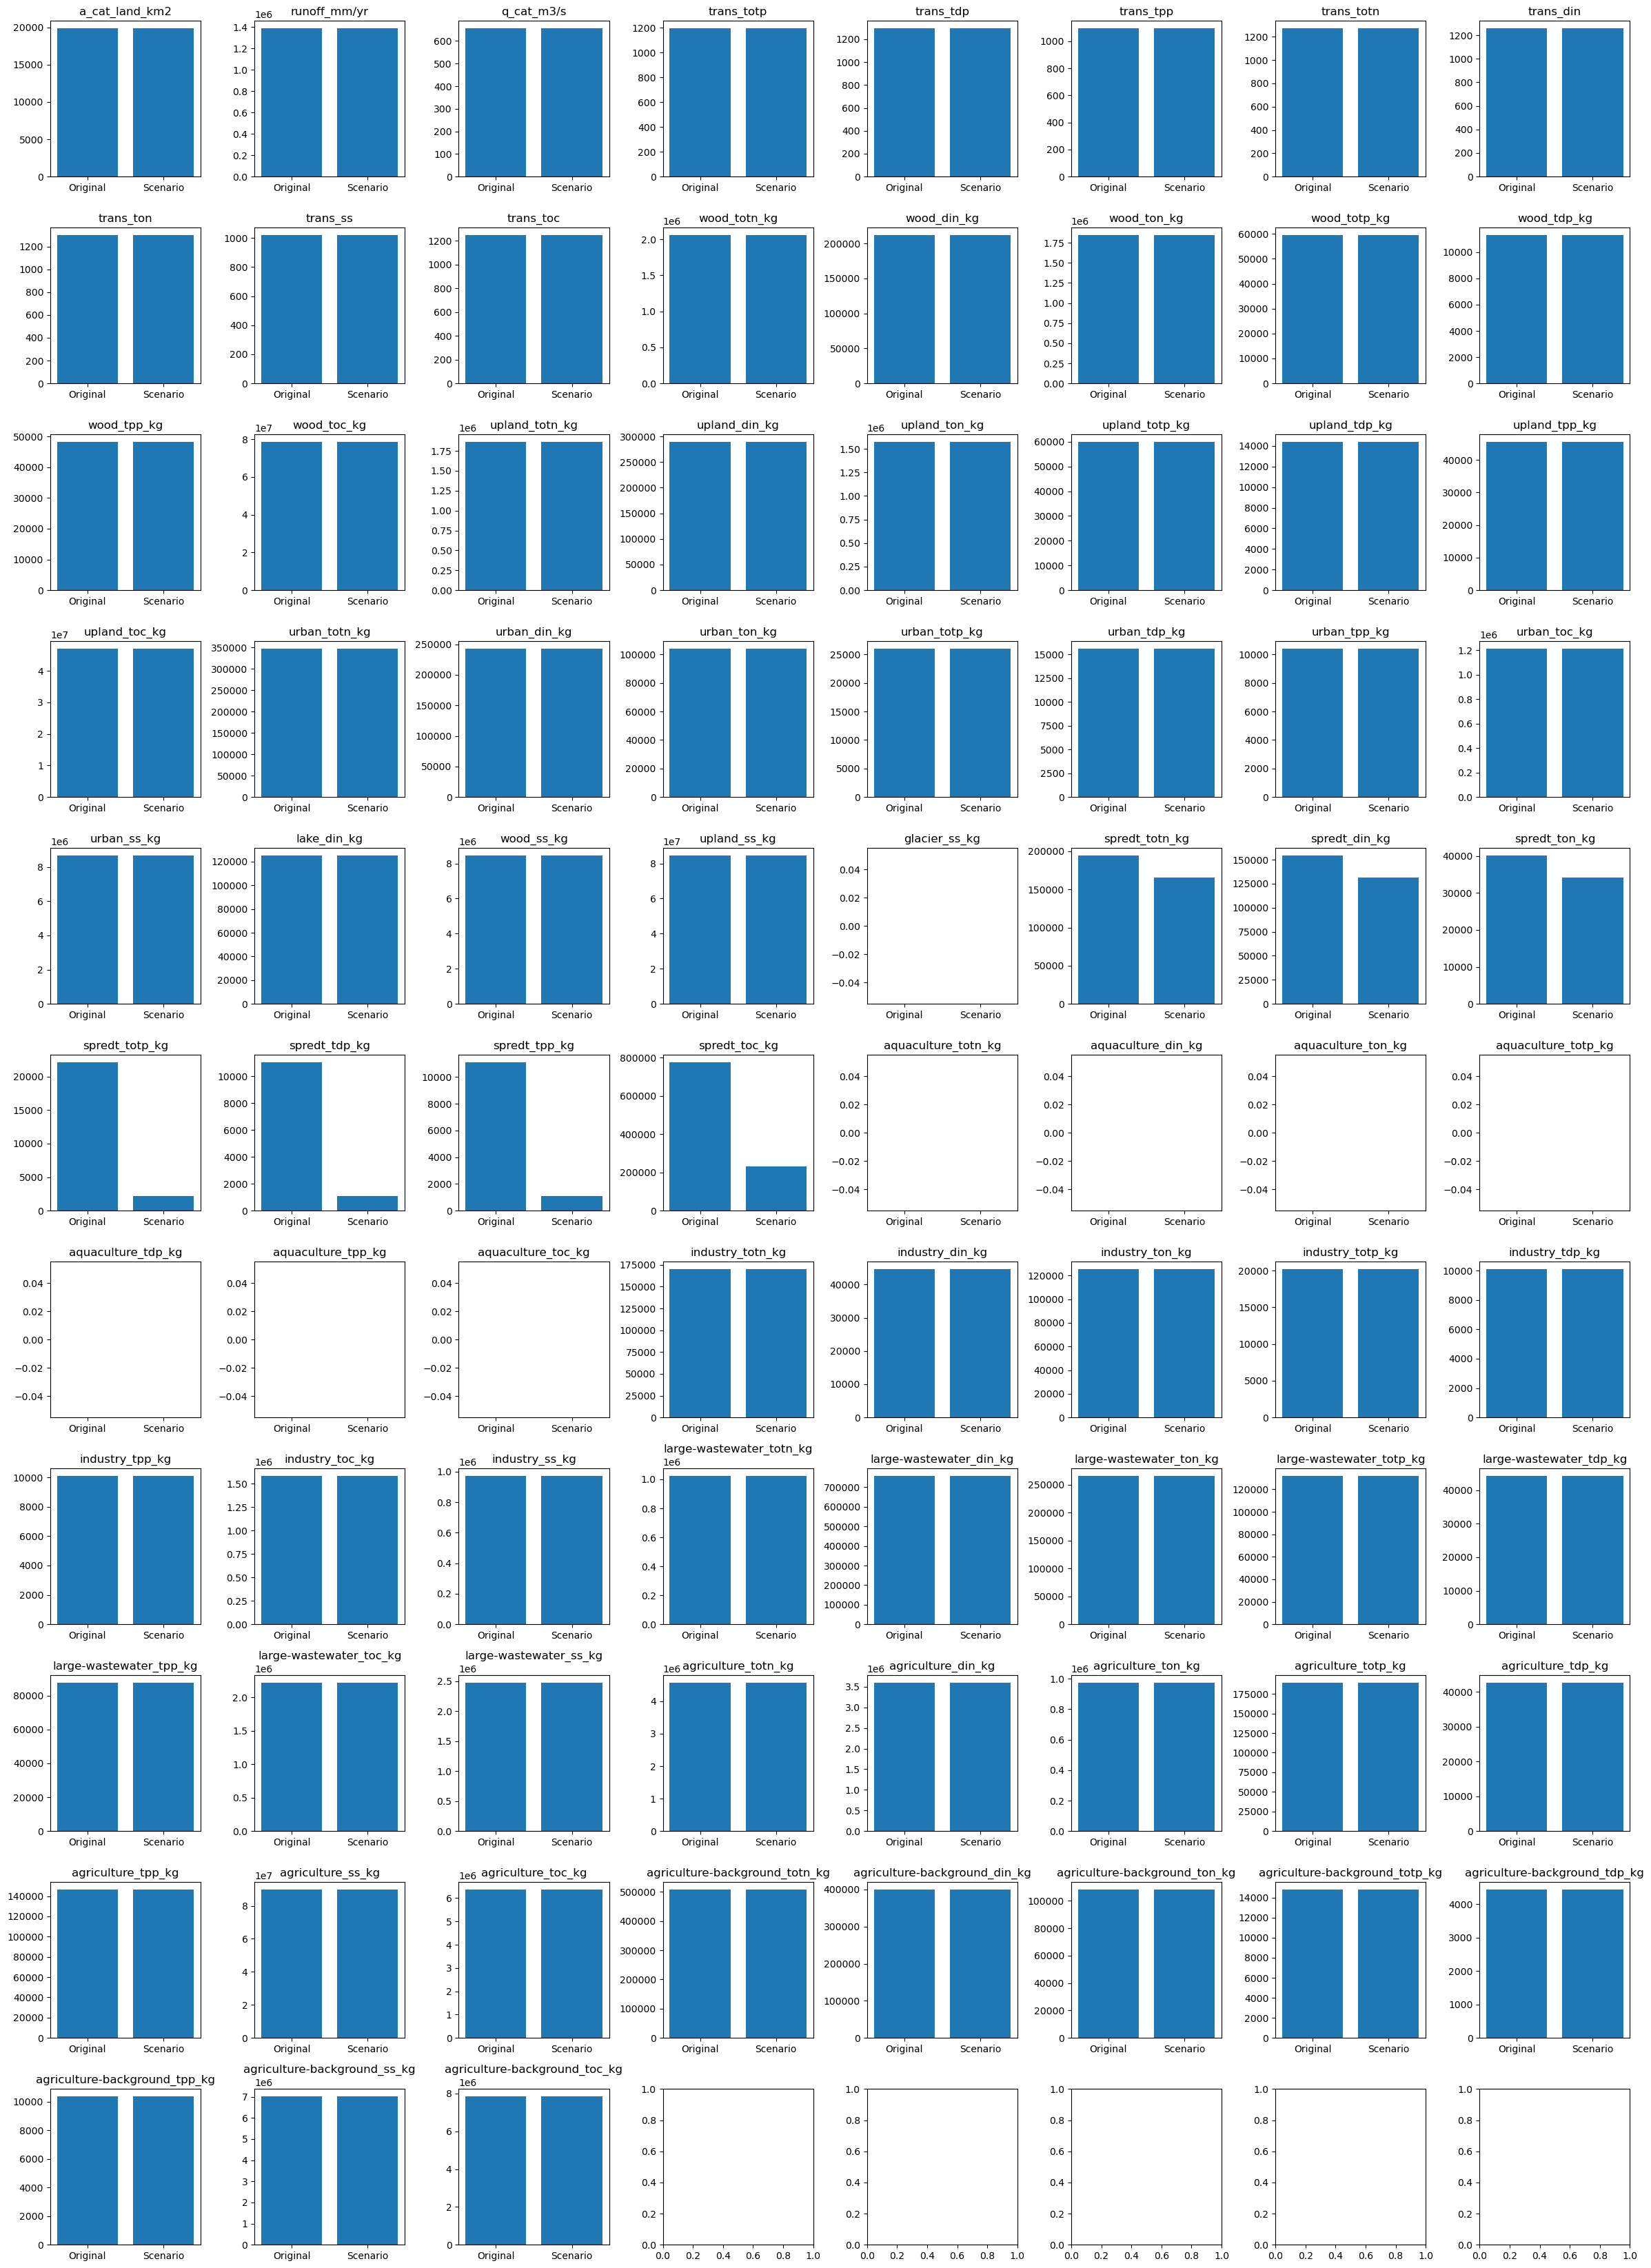

In [9]:
# Plot national total for each model input by source for the last year
# Just to check that only small wastewater has changed.
n_subplots = len(orig_df.select_dtypes(include="number").columns)
n_cols = 8
fig, axes = plt.subplots(
    int(n_subplots / n_cols) + 1,
    n_cols,
    figsize=(n_cols * 3, (int(n_subplots / n_cols) + 1) * 3),
)
axes = axes.flatten()
for i, col in enumerate(orig_df.select_dtypes(include="number").columns):
    axes[i].bar(["Original", "Scenario"], [orig_df.sum()[col], scen_df.sum()[col]])
    axes[i].set_title(col)

plt.tight_layout()